# Chapter 5: Pretraining on Unlabeled Data

In [60]:
from importlib.metadata import version

pkgs = [
    'matplotlib',
    'numpy',
    'tiktoken',
    'torch',
    'tensorflow'
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.8
numpy version: 2.4.0
tiktoken version: 0.12.0
torch version: 2.9.1
tensorflow version: 2.20.0


## 5.1 Evaluating Generative Text Models

### 5.1.1 Using GPT to Generate Text

In [4]:
# Initialize GPT model from Chapter 4
import torch
from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Shortened context length (original length: 1024)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-key-value bias
}

torch.manual_seed(0)

model = GPTModel(GPT_CONFIG_124M)
model.eval()  # Set the model to evaluation mode to disable dropout

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

We apply 0.1 drop rate above but it is common to train LLMs without dropout nowadays.

Modern LLMs also do not use bias vectors in the `nn.Linear` layers for the query, key and value matrices: `"qkv_bias"=False`.

We reduced the context length from 1024 to 256 to reduce computational resources for training.

We will also use the `generate_text_simple` function defined in Chapter 4 to generate text from our trained GPT model, with two utility functions, `text_to_token_ids` and `token_ids_to_text`, to convert between text and token IDs.

In [5]:
import tiktoken
from llms_from_scratch.ch04 import generate_text_simple

# Utility functions for text-token conversion

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension

    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension

    return tokenizer.decode(flat.tolist())

In [6]:
start_context = "Every effort moves you"

tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Initi Nileuriynski foreNe respective dip lac arsen


### 5.1.2 Calculating the Text Generation Loss

In [7]:
# Two input batches
input_texts = [
    "every effort moves",
    "I really like"
]
inputs = torch.cat([text_to_token_ids(text, tokenizer) for text in input_texts], dim=0)
print("Inputs shape:", inputs.shape)  # Should be (2, sequence_length)
print("Inputs:\n", inputs)

Inputs shape: torch.Size([2, 3])
Inputs:
 tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])


In [8]:
# targets are the inputs shifted by one position
target_texts = [
    " effort moves you",
    " really like chocolate"
]
targets = torch.cat([text_to_token_ids(text, tokenizer) for text in target_texts], dim=0)
print("Targets shape:", targets.shape)  # Should be (2, sequence_length)
print("Targets:\n", targets)

Targets shape: torch.Size([2, 3])
Targets:
 tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


Now we feed `inputs` to the model to get the logits.

In [9]:
with torch.no_grad(): # Disable gradient calculation
    logits = model(inputs)

probs = torch.softmax(logits, dim=-1)
print("Logits shape:", logits.shape)  # Should be (2, num_tokens, vocab_size)

Logits shape: torch.Size([2, 3, 50257])


In [10]:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print("Predicted token IDs shape:", token_ids.shape)  # Should be (2, num_tokens, 1)
print("Predicted token IDs:\n", token_ids)

Predicted token IDs shape: torch.Size([2, 3, 1])
Predicted token IDs:
 tensor([[[47766],
         [49992],
         [16634]],

        [[28961],
         [23252],
         [ 6895]]])


In [11]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Predicted batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Predicted batch 1:  Lydia shockinglyppo


We want to evaluate the performance of the model's generated text numerically via a loss function so that we can measure "how far" the generated tokens are from the correct predictions (the targets).

The model training aims to increase the softmax probability in the index positions corresponding to the correct target token IDs. This probability is also used in the evaluation metric we will implement next to numerically assess the model's generated outputs.

For each of the two input texts, we can check the initial softmax probabilities corresponding to the target tokens:

In [12]:
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Softmax probabilities for target tokens in batch 1:", target_probs_1)

text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Softmax probabilities for target tokens in batch 2:", target_probs_2)

Softmax probabilities for target tokens in batch 1: tensor([1.4901e-05, 6.1409e-05, 1.8651e-05])
Softmax probabilities for target tokens in batch 2: tensor([8.8184e-06, 2.3608e-05, 2.9832e-05])


We want to maximize all these values, bringing them close to a probability of 1.0.

In mathematical optimization, we usually maximize the logarithm of the probability instead of the probability itself, as it is numerically more stable and easier to work with. Thus, we will maximize the sum of the log probabilities of the target tokens across all positions and both input texts.

In [13]:
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print("Log probabilities of target tokens:", log_probs)

Log probabilities of target tokens: tensor([-11.1141,  -9.6979, -10.8896, -11.6387, -10.6539, -10.4199])


In [14]:
# Calculate average log probability
avg_log_probs = torch.mean(log_probs)
print("Average log probability of target tokens:", avg_log_probs)

Average log probability of target tokens: tensor(-10.7357)


The goal is to get the average log probability as close to 0 as possible (since log(1) = 0).

In deep learning, instead of maximizing the average log probability, we usually minimize the *negative average log probability*, which is known as the *cross-entropy loss*.

In [15]:
neg_avg_log_probs = avg_log_probs * -1
print("Negative average log probability (cross-entropy loss):", neg_avg_log_probs)

Negative average log probability (cross-entropy loss): tensor(10.7357)


The **cross-entropy loss** measures the difference between two probability distributions, the true distribution of labels (tokens in a dataset) and the predicted distribution from a model (token probabilities generated by an LLM).

We can get the same results using the built-in `cross_entropy` function from PyTorch. Before we apply it, we need to check the shapes of the logits and targets.

In [16]:
print("Logits shape:", logits.shape)   # Shape: (2, num_tokens, vocab_size)
print("Targets shape:", targets.shape) # Shape: (2, num_tokens)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


To apply `cross_entropy`, we need to flatten these tensors by combining them over the batch dimension:

In [17]:
logits_flat = logits.flatten(0, 1)  # Shape: (2 * num_tokens, vocab_size)
targets_flat = targets.flatten()    # Shape: (2 * num_tokens)

print("Flattened logits shape:", logits_flat.shape)
print("Flattened targets shape:", targets_flat.shape)

Flattened logits shape: torch.Size([6, 50257])
Flattened targets shape: torch.Size([6])


The `cross_entropy` function will automatically take care of applying the softmax and log-probability over those token indices in the logits that are to be maximized.

In [18]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross-entropy loss:", loss)

Cross-entropy loss: tensor(10.7357)


**Perplexity** is a measure used alongside cross-entropy loss to evaluate the performance of models in tasks like language modeling.

Perplexity measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset. A *lower* perplexity indicates that the model predictions are closer to the actual distribution.

Perplexity is calculated as the exponentiation of the cross-entropy loss:

In [19]:
perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Perplexity: tensor(45967.7305)


Perplexity is considered more interpretable than the raw loss because it signifies the effective vocabulary size about which the model is uncertain at each step.

For example, given the current vocabulary size of 50,257 tokens, this perplexity value would translate to the model being unsure about which among 45968 tokens in the vocabulary to generate as the next token.

### 5.1.3 Calculating the Training and Validation Set Losses

For demo purposes, we will use a very small text dataset, the "The Verdict" short story in Chapter 2.

In [20]:
import os
import requests

filepath = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(filepath):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(text_data)
else:
    with open(filepath, "r", encoding="utf-8") as f:
        text_data = f.read()


total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters in dataset: {total_characters}")
print(f"Total tokens in dataset: {total_tokens}")

Total characters in dataset: 20479
Total tokens in dataset: 5145


Next we divide the dataset into training and validation sets and we will use the dataloader defined in Chapter 2 to iterate over these datasets and calculate the average loss on both sets.

We will train the model with training data presented in similarly sized chunks for simplicity and efficiency. However, in practice, it can be beneficial to train an LLM with variable-length inputs to help the LLM to better generalize across different types of inputs when it is being used.

In [21]:
from llms_from_scratch.ch02 import create_dataloader_v1
torch.manual_seed(0)

# Train/Val ratio
train_ratio = 0.9
split_idx = int(total_characters * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [22]:
train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [23]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`.")
    
if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`.")

We used a relatively small batch size of 2 to reduce computational resource requirements for this demo. In practice, larger batch sizes (e.g., 128, 256, or even 512) are often used to stabilize training and improve convergence.

For example, Llama 2 7B was trained with a batch size of 1024.

In [24]:
print("Train loader:")
for i, (x,y) in enumerate(train_loader):
    print(f"batch {i+1} - Input batch shape: {x.shape}, Target batch shape: {y.shape}")

print("Validation loader:")
for i, (x,y) in enumerate(val_loader):
    print(f"batch {i+1} - Input batch shape: {x.shape}, Target batch shape: {y.shape}")

Train loader:
batch 1 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 2 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 3 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 4 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 5 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 6 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 7 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 8 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
batch 9 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])
Validation loader:
batch 1 - Input batch shape: torch.Size([2, 256]), Target batch shape: torch.Size([2, 256])


In [25]:
# Sanity check the token sizes are in the expected ballpark
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print(f"Total tokens in training loader: {train_tokens}")
print(f"Total tokens in validation loader: {val_tokens}")
print("All tokens:", train_tokens + val_tokens)

Total tokens in training loader: 4608
Total tokens in validation loader: 512
All tokens: 5120


Next we need a utility function `calc_loss_batch` to calculate the cross-entropy loss for a given batch of input and target token IDs. In addition, we will have `calc_loss_loader` to compute the loss over all the batches in a dataloader.

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)

    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),  # Flatten the logits to shape (batch_size * seq_length, vocab_size)
        target_batch.flatten()  # Flatten the targets to shape (batch_size * seq_length)
    )
    return loss


def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0.
    if len(dataloader) == 0:
        return float('nan')

    elif num_batches is None:
        # Use all batches in the dataloader
        num_batches = len(dataloader)
    else:
        # Reduce the number of batches to match the total number of batches in the dataloader
        # if num_batches exceeds the number of batches in the dataloader
        num_batches = min(num_batches, len(dataloader))

    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    avg_loss = total_loss / num_batches
    return avg_loss

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

torch.manual_seed(0)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Training set loss: {train_loss:.4f}")
print(f"Validation set loss: {val_loss:.4f}")

Using device: cpu
Training set loss: 10.9821
Validation set loss: 10.9975


## 5.2 Training an LLM

We will implement a simple training loop to train our GPT model on the training dataset and evaluate it on the validation dataset after each epoch.

In [28]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()

    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
        model.train()

In [29]:
def train_model_simple(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs,
        eval_freq,
        eval_iter,
        start_context,
        tokenizer
):
    # Initialize lists to track losses and tokens seen
    train_losses = []
    val_losses = []
    track_tokens_seen = []
    tokens_seen = 0
    global_step = -1


    # Main training loop
    for epoch in range(num_epochs):
        model.train() # Set the model to training mode

        for input_batch, target_batch in train_loader:
            # Reset loss gradients from previous batch iteration
            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # Evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

*Adam* optimizer is widely used for training deep learning models. However, we will use the *AdamW* optimizer, a variant of Adam that improves model complexity and prevent overfitting by penalizing large weights.

In [30]:
import time
start_time = time.time()

torch.manual_seed(0)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Total training time: {execution_time_minutes:.2f} minutes")

Epoch 1 (Step 000000): Train loss 9.844, Val loss 10.086
Epoch 1 (Step 000005): Train loss 8.093, Val loss 8.339
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000010): Train loss 6.754, Val loss 7.071
Epoch 2 (Step 000015): Train loss 6.067, Val loss 6.650
Every effort moves you.                                                 
Epoch 3 (Step 000020): Train loss 5.814, Val loss 6.519
Epoch 3 (Step 000025): Train loss 5.655, Val loss 6.485
Every effort moves you                                                  
Epoch 4 (Step 000030): Train loss 5.650, Val loss 6.571
Epoch 4 (Step 000035): Train loss 5.021, Val loss 6.485
Every effort moves you he had a I had a a--                                          
Epoch 5 (Step 000040): Train loss 4.626, Val loss 6.476
Every effort moves you, and in the picture. Gisburn's the picture. Gisburn's, and--and--and, I had a little a little to the last I had the last--and it--and a, and it--and the picture
Epoch 

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax1.plot(epochs_seen, train_losses, label='Training loss')
    ax1.plot(epochs_seen, val_losses, label='Validation loss', linestyle='-.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny() # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel('Tokens seen')

    fig.tight_layout()
    plt.show()

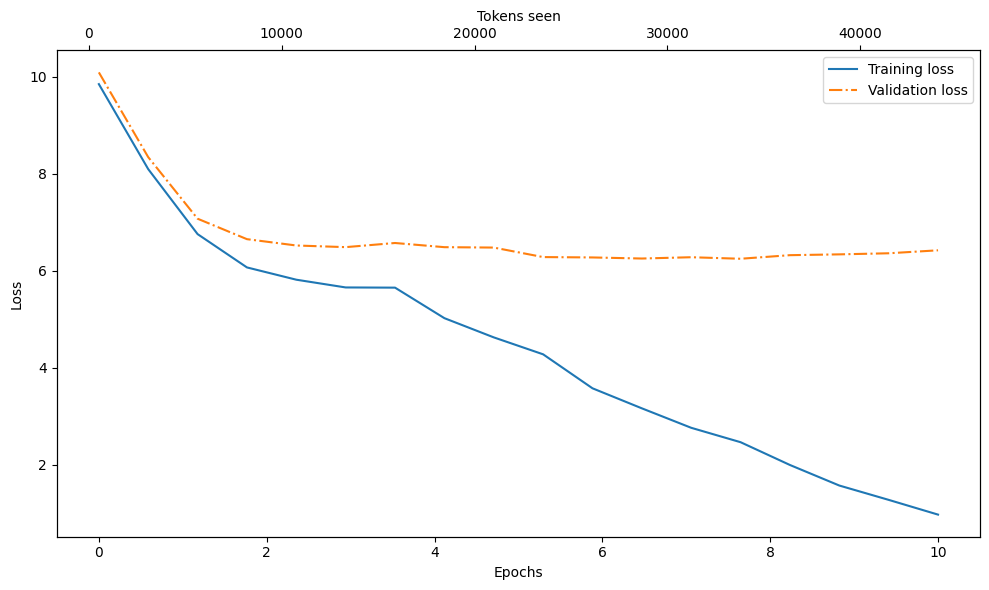

In [32]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The model starts out generating incomprehensible text, but as training progresses, it begins to produce more coherent and contextually relevant outputs. However, given the small size of our dataset, the model starts to overfit after a few epochs, as indicated by the divergence between training and validation losses.

## 5.3 Decoding Strategies to Control Randomness

The `generate_text_simple` function we defined in Chapter 4 uses a greedy decoding strategy, which selects the token with the highest probability at each step. While this approach is straightforward, it can lead to repetitive and less diverse text generation.

In [33]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Generated text:\n", token_ids_to_text(token_ids, tokenizer))

Generated text:
 Every effort moves you?"

"Yes--quite insensible to the fact with a laugh: "Yes--and by me!"




### 5.3.1 Temperature Scaling

**Temperature scaling** is a technique used to add a probabilistic selection process to the next-token generation task.

In the `generate_text_simple` function, we always sampled the token with the highest probability as the next token using `torch.argmax`, which is known as *greedy decoding*.

To generate text with more variety, we can replace `torch.argmax` with a function that samples from a probability distribution.

In [40]:
# demo vocabulary
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v:k for k,v in vocab.items()}

In [41]:
# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [42]:
# Greedy decoding
probs = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probs).item()
print(f"Greedy decoding selected token: '{inverse_vocab[next_token_id]}' with probability {probs[next_token_id]:.4f}")

Greedy decoding selected token: 'forward' with probability 0.5721


To implement a probalistic sampling process, we will replace `torch.argmax` with `torch.multinomial`:

In [45]:
torch.manual_seed(0)  # For reproducibility
next_token_id = torch.multinomial(probs, num_samples=1).item()
print(f"Probabilistic sampling selected token: '{inverse_vocab[next_token_id]}' with probability {probs[next_token_id]:.4f}")

Probabilistic sampling selected token: 'toward' with probability 0.3576


The `torch.multinomial` function samples the next token proportional to its probability score. In other words, `'torward'` is the most likely token and will be selected by `multinomial` most of the time, but not all the time.

In [46]:
def print_sampled_tokens(probs):
    torch.manual_seed(0)  # For reproducibility
    sample = [torch.multinomial(probs, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probs))

    for i, freq in enumerate(sampled_ids):
        print(f"Token: '{inverse_vocab[i]}', Frequency: {freq}, Estimated Probability: {freq/1000:.4f}")

In [47]:
print_sampled_tokens(probs)

Token: 'closer', Frequency: 50, Estimated Probability: 0.0500
Token: 'every', Frequency: 1, Estimated Probability: 0.0010
Token: 'effort', Frequency: 0, Estimated Probability: 0.0000
Token: 'forward', Frequency: 562, Estimated Probability: 0.5620
Token: 'inches', Frequency: 5, Estimated Probability: 0.0050
Token: 'moves', Frequency: 0, Estimated Probability: 0.0000
Token: 'pizza', Frequency: 0, Estimated Probability: 0.0000
Token: 'toward', Frequency: 373, Estimated Probability: 0.3730
Token: 'you', Frequency: 9, Estimated Probability: 0.0090


The word `"forward"` is sampled most of the time, but other tokens are also sampled occasionally, demonstrating the probabilistic nature of this sampling method.

We can further control the distribution and selection process via a concept called *temperature scaling*.

**Temperature scaling** divides the logits by a number greater than 0:

In [48]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature

    return torch.softmax(scaled_logits, dim=0)

- Temperature > 1: more uniformly distributed token probabilities, leading to more diverse but potentially less coherent text.
- Temperature < 1: more confident (sharper and more peaky) token probabilities, leading to more focused and coherent text but less diversity.

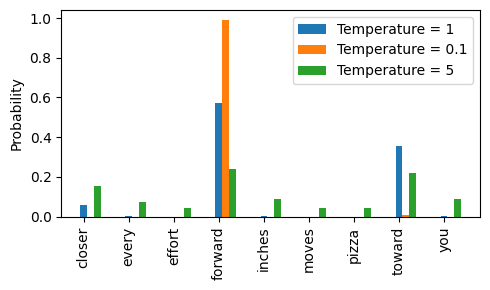

In [49]:
# Temperature values
temperatures = [1, 0.1, 5] # [original, higher configuration, lower configuration]

# Calculate scaled probabilities
scaled_probs = [softmax_with_temperature(next_token_logits, temp) for temp in temperatures]

# Plot
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, temp in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label=f"Temperature = {temp}")

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

A temperature of 1 divides the logits by 1 before applying softmax, which leaves the original distribution unchanged.

In [51]:
# temperature = 0.1
print_sampled_tokens(scaled_probs[1])

Token: 'closer', Frequency: 0, Estimated Probability: 0.0000
Token: 'every', Frequency: 0, Estimated Probability: 0.0000
Token: 'effort', Frequency: 0, Estimated Probability: 0.0000
Token: 'forward', Frequency: 984, Estimated Probability: 0.9840
Token: 'inches', Frequency: 0, Estimated Probability: 0.0000
Token: 'moves', Frequency: 0, Estimated Probability: 0.0000
Token: 'pizza', Frequency: 0, Estimated Probability: 0.0000
Token: 'toward', Frequency: 16, Estimated Probability: 0.0160
Token: 'you', Frequency: 0, Estimated Probability: 0.0000


In [52]:
# temperature = 5
print_sampled_tokens(scaled_probs[2])

Token: 'closer', Frequency: 139, Estimated Probability: 0.1390
Token: 'every', Frequency: 65, Estimated Probability: 0.0650
Token: 'effort', Frequency: 43, Estimated Probability: 0.0430
Token: 'forward', Frequency: 257, Estimated Probability: 0.2570
Token: 'inches', Frequency: 75, Estimated Probability: 0.0750
Token: 'moves', Frequency: 45, Estimated Probability: 0.0450
Token: 'pizza', Frequency: 54, Estimated Probability: 0.0540
Token: 'toward', Frequency: 231, Estimated Probability: 0.2310
Token: 'you', Frequency: 91, Estimated Probability: 0.0910


### 5.3.2 Top-k Sampling

Temperature scaling affects the entire probability distribution to increase the randomness of token selection. One downside of this approach is that it sometimes leads to grammatically incorrect or nonsensical text, especially when the temperature is set too high.

**Top-k sampling**, when combined with probabilistic sampling and temperature scaling, can improve the text generation quality by limiting the selection to the top *k* most probable tokens.

In top-k sampling, we can restrict the sampled tokens to the top-k most like tokens and exclude all other tokens from the selection process by masking their probabilities to zero before sampling.

The top-k approach replaces all nonselected logits with `-inf` before applying softmax, effectively setting their probabilities to zero, and then the remaining probabilities are renormalized to sum to 1. This way, the sampling process only considers the top-k tokens, leading to more coherent and contextually relevant text generation.

In [53]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(f"Top-{top_k} logits: {top_logits}")
print(f"Top-{top_k} token positions: {top_pos}")


Top-3 logits: tensor([6.7500, 6.2800, 4.5100])
Top-3 token positions: tensor([3, 7, 0])


In [54]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # Identify logits less than the min of top-k logits
    input=torch.tensor(float('-inf')),            # Assign -inf to those logits
    other=next_token_logits                       # Retain original logits for top-k tokens
)
print("New logits after applying top-k sampling:\n", new_logits)

New logits after applying top-k sampling:
 tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [55]:
# Apply softmax to turn new_logits into probabilities
topk_probs = torch.softmax(new_logits, dim=0)
print("Probabilities after applying top-k sampling:\n", topk_probs)

Probabilities after applying top-k sampling:
 tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the Text Generation Function

In [56]:
def generate(
        model,
        idx,
        max_new_tokens,
        context_size,
        temperature=0.,
        top_k=None,
        eos_id=None
):
    # For-loop setup - same as before: get logits, and only focus on the last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop context if needed

        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # Focus on the last time step

        # NEW: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k logits
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float('-inf')).to(logits.device),
                other=logits
            )

        # NEW: Apply temperature scaling
        if temperature > 0.:
            logits = logits / temperature

            # NEW: numerical stability fix
            # - subtract row-wise max before applying softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1) # Shape: (batch_size, context_size)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # Shape: (batch_size, 1)

        # Otherwise: greedy decoding
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Shape: (batch_size, 1)

        if idx_next == eos_id:
            # Stop generating early if end-of-sequence token is generated
            break

        # Append sampled token to the sequence
        idx = torch.cat((idx, idx_next), dim=1)  # Shape: (batch_size, num_tokens + 1)

    return idx

In [58]:
torch.manual_seed(0)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=1.4,
    top_k=25
)
print("Generated text with temperature scaling and top-k sampling:\n", token_ids_to_text(token_ids, tokenizer))

Generated text with temperature scaling and top-k sampling:
 Every effort moves you found his eyes over that Mrs.
 " the room, the tips laugh


## 5.4 Loading and Saving Model Weights

In [ ]:
# Saving model weights - `state_dict`
torch.save(model.state_dict(), "model.pth")

In [ ]:
# Loading model weights
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

We may also need to save the additional parameters used in the optimizer with the model weights:

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [ ]:
# Loading model and optimizer weights
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 Loading Pretrained Weights from OpenAI

In [61]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [ ]:
from llms_from_scratch.ch05 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(0)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))